<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Scratch_CNN_benign_vs_malign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **benign vs malign samples**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*



##1.Data Loading

In [114]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [136]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
#ROC-AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.wrappers.scikit_learn import KerasClassifier

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
PLOTS_PATH =  os.path.join(base_path, 'plots/Benign-Malign')
train_img_path = os.path.join(base_path, 'numpy data/train_tensor.npy')
train_label_path = os.path.join(base_path, 'numpy data/train_labels.npy')
test_img_path = os.path.join(base_path, 'numpy data/public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'numpy data/public_test_labels.npy')

MODEL_PATH = os.path.join(base_path, "models/Benign-Malign")


print("Done")

Done


In [137]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


In [138]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.7*len(dataset))]
  valid_data_split = dataset[int(0.7*len(dataset)):]
  train_labels_split = labels[:int(0.7*len(labels))]
  valid_labels_split = labels[int(0.7*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify benign and malign cases 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # malign
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr

Done


In [139]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)


Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


In [140]:
# Visualization Data Histogram
def plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

print("Done")

Done


##2.Data preprocessing

Currently, our data sits on a drive as numpy files (**.npy**), so the steps for getting it into our network are roughly:



In [141]:
#1: Mass, benign
#2: Mass, malignant
#3: Calcification, benign
#4: Calcification, malignant

#count #of masses and #of calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)

print("Benign Masses samples: \t", counts[0])
print("Malign Masses samples: \t", counts[1])
print("Benign Calc samples: \t", counts[2])
print("Malign Calc samples: \t", counts[3])

Benign Masses samples: 	 620
Malign Masses samples: 	 598
Benign Calc samples: 	 948
Malign Calc samples: 	 510


In [142]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])
print()

train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

Benign samples:  1568
Malign samples:  1108

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [143]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)                                  

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)


In [144]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./65535
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break



(20, 150, 150, 1)
(20,)


##3.Defining CNN 


In [ ]:
es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

checkpoint_filepath =  os.path.join(base_path, 'models/Benign-Malign/best weights dummy')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

def build_model(loss_function, eval_metric=["acc"]):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  #model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001
              metrics=["acc"]) 
  
  return model 

print("Done")

Done


##4.CNN Compilation:



In [ ]:
from keras import optimizers 

model_0 = build_model("binary_crossentropy", "acc")

model_0.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
history = model_0.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback])


Epoch 1/100
93/93 [==============================] - 9s 19ms/step - loss: 0.6918 - acc: 0.5941 - val_loss: 0.6868 - val_acc: 0.5688
Epoch 2/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6864 - acc: 0.6166 - val_loss: 0.6810 - val_acc: 0.6087
Epoch 3/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6765 - acc: 0.5970 - val_loss: 0.6694 - val_acc: 0.5738
Epoch 4/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6594 - acc: 0.6079 - val_loss: 0.6523 - val_acc: 0.5800
Epoch 5/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6444 - acc: 0.6236 - val_loss: 0.6349 - val_acc: 0.6288
Epoch 6/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6478 - acc: 0.6501 - val_loss: 0.6368 - val_acc: 0.6150
Epoch 7/100
93/93 [==============================] - 1s 13ms/step - loss: 0.6437 - acc: 0.6302 - val_loss: 0.6325 - val_acc: 0.6325
Epoch 8/100
93/93 [==============================] - 1s 14ms/step - loss: 0.

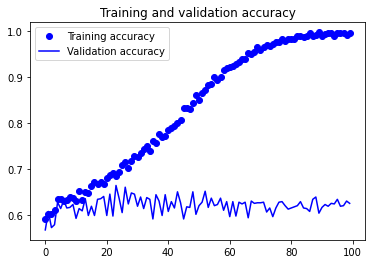

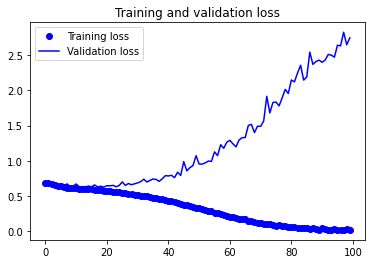

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model_0.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 5ms/step - loss: 2.9523 - acc: 0.6281
0.628125011920929


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70       219
         1.0       0.47      0.54      0.50       117

    accuracy                           0.62       336
   macro avg       0.60      0.60      0.60       336
weighted avg       0.64      0.62      0.63       336



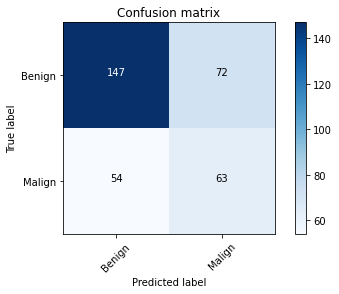

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
model_0.load_weights(checkpoint_filepath)
plot_confusion_matrix(model_0,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

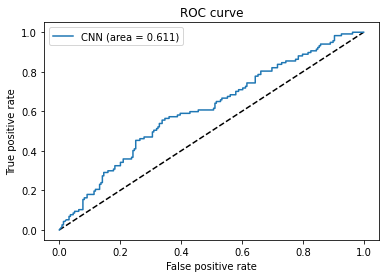

In [ ]:
#ROC-AUC 
plot_AUC(model_0, test_images, test_labels)

In [ ]:
predictions = get_model_pred_prob(model_0, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

##5.Dealing with imbalanced dataset: 

### CNN Model No.1 Weighted Class Approah

In [ ]:
from sklearn.utils import class_weight

#compute class_weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels_split),
                                                 train_labels_split)

class_weights = {0: class_weights[0],
                 1: class_weights[1]}

print(class_weights)

{0: 0.8623388581952118, 1: 1.189961880559085}


In [ ]:
model_1 = build_model("binary_crossentropy", "acc")

#model.summary()

history = model_1.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=class_weights,
                    callbacks=[model_checkpoint_callback])


Epoch 1/100
93/93 [==============================] - 2s 17ms/step - loss: 0.6932 - acc: 0.4946 - val_loss: 0.7011 - val_acc: 0.4325
Epoch 2/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6872 - acc: 0.5093 - val_loss: 0.6909 - val_acc: 0.4913
Epoch 3/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6738 - acc: 0.5565 - val_loss: 0.6592 - val_acc: 0.5987
Epoch 4/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6556 - acc: 0.5938 - val_loss: 0.6331 - val_acc: 0.6538
Epoch 5/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6392 - acc: 0.6009 - val_loss: 0.6370 - val_acc: 0.6037
Epoch 6/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6452 - acc: 0.5860 - val_loss: 0.6387 - val_acc: 0.6087
Epoch 7/100
93/93 [==============================] - 1s 14ms/step - loss: 0.6262 - acc: 0.6479 - val_loss: 0.6317 - val_acc: 0.6000
Epoch 8/100
93/93 [==============================] - 1s 14ms/step - loss: 0.

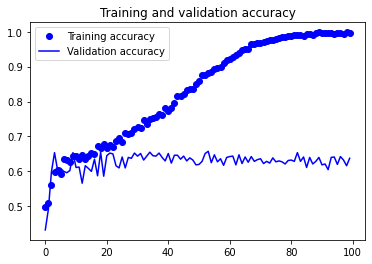

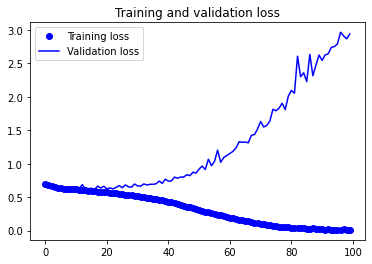

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model_1.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 5ms/step - loss: 2.8648 - acc: 0.6344
0.6343749761581421


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71       219
         1.0       0.48      0.58      0.53       117

    accuracy                           0.64       336
   macro avg       0.62      0.62      0.62       336
weighted avg       0.66      0.64      0.64       336



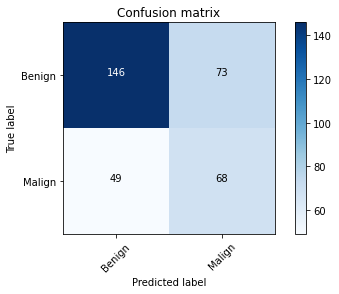

In [ ]:
model_1.load_weights(checkpoint_filepath)
plt_1 = plot_confusion_matrix(model_1,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_CM.png'))

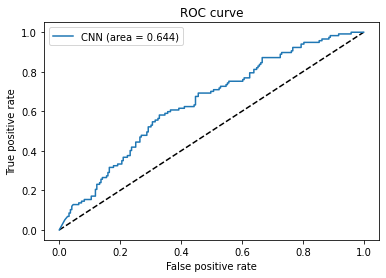

In [ ]:
plot_AUC(model_1, test_images, test_labels)

In [ ]:
predictions = get_model_pred_prob(model_1, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

### CNN Model No.2 Undersampling Majority Class: 
picking up same number of samples of data for both majority and minority classes.

![img](https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png?resize=768%2C399&ssl=1)

In [ ]:
#undersampling
def undersample(dataset, labels):
  unique, counts = np.unique(labels, return_counts=True)
  #print("Benign samples: ", counts[0])
  #print("Malign samples: ", counts[1])

  num_elems = np.min(counts)
  zipped = list(zip(dataset, labels))

  undersampled_images = np.zeros((num_elems*2,) +  dataset[0].shape) #(num_elems, 150, 150, 1)
  undersampled_labels = np.zeros((num_elems*2,))                     #(num_elems*2, )
  #print(undersampled_beign_class.shape)

  i = 0
  benign_counts = 0
  for image, label in zipped:
    if label == 0 and benign_counts < num_elems:
      undersampled_images[i] = image 
      undersampled_labels[i] = label 
      benign_counts += 1
      i += 1 

    elif label == 1:
      undersampled_images[i] = image 
      undersampled_labels[i] = label 
      i += 1 

    if i == num_elems*2:
      break

  return undersampled_images, undersampled_labels

In [ ]:
undersampled_images, undersampled_labels = undersample(train_images, train_labels)

unique, counts = np.unique(undersampled_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])

Benign samples:  1108
Malign samples:  1108


In [ ]:
# split dataset into training and validation set 70-30
us_train_images_split, us_valid_images_split, us_train_labels_split, us_valid_labels_split = split_train_val(undersampled_images, undersampled_labels)  

(1551, 150, 150, 1)
(665, 150, 150, 1)
(1551,)
(665,)


In [ ]:
model_2 = build_model("binary_crossentropy", "acc")

#model_2.summary()

history = model_2.fit(train_datagen.flow(us_train_images_split,
                                       us_train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(us_train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(us_valid_images_split,
                                       us_valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(us_valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
77/77 [==============================] - 2s 19ms/step - loss: 0.6929 - acc: 0.5755 - val_loss: 0.7865 - val_acc: 0.2773
Epoch 2/100
77/77 [==============================] - 1s 14ms/step - loss: 0.6823 - acc: 0.5968 - val_loss: 0.7611 - val_acc: 0.2773
Epoch 3/100
77/77 [==============================] - 1s 14ms/step - loss: 0.6708 - acc: 0.6103 - val_loss: 0.8038 - val_acc: 0.2773
Epoch 4/100
77/77 [==============================] - 1s 14ms/step - loss: 0.6630 - acc: 0.5860 - val_loss: 0.8443 - val_acc: 0.2773
Epoch 5/100
77/77 [==============================] - 1s 14ms/step - loss: 0.6598 - acc: 0.5991 - val_loss: 0.8001 - val_acc: 0.3258
Epoch 6/100
77/77 [==============================] - 1s 14ms/step - loss: 0.6323 - acc: 0.6255 - val_loss: 0.6717 - val_acc: 0.5758
Epoch 7/100
77/77 [==============================] - 1s 13ms/step - loss: 0.6326 - acc: 0.6233 - val_loss: 0.6523 - val_acc: 0.6333
Epoch 8/100
77/77 [==============================] - 1s 14ms/step - loss: 0.

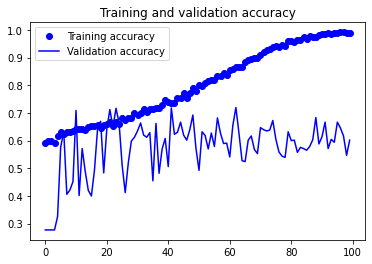

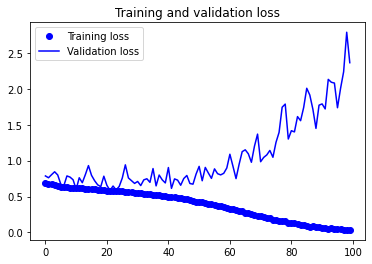

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model_2.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 5ms/step - loss: 1.9920 - acc: 0.5906
0.590624988079071


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.70      0.65      0.68       219
         1.0       0.43      0.49      0.46       117

    accuracy                           0.60       336
   macro avg       0.57      0.57      0.57       336
weighted avg       0.61      0.60      0.60       336



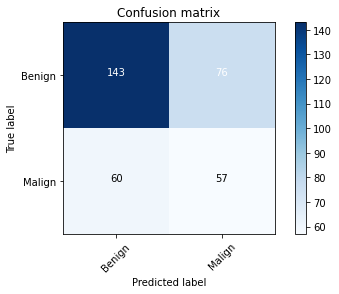

In [ ]:
plt_2 = model_2.load_weights(checkpoint_filepath)
plot_confusion_matrix(model_2,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_2.savefig(os.path.join(PLOTS_PATH, 'model_2_CM.png'))

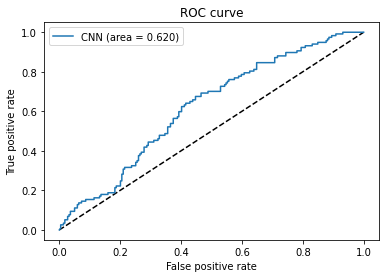

In [ ]:
plot_AUC(model_2, test_images, test_labels)

In [ ]:
predictions = get_model_pred_prob(model_2, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

### CNN Model No.3 Data augmentation.

In [145]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


In [ ]:
model_3 = build_model("binary_crossentropy", "acc")

#model_3.summary()

history = model_3.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
93/93 [==============================] - 5s 44ms/step - loss: 0.6770 - acc: 0.6132 - val_loss: 0.6875 - val_acc: 0.5688
Epoch 2/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6874 - acc: 0.5822 - val_loss: 0.6897 - val_acc: 0.5688
Epoch 3/100
93/93 [==============================] - 4s 43ms/step - loss: 0.6875 - acc: 0.5754 - val_loss: 0.7238 - val_acc: 0.5688
Epoch 4/100
93/93 [==============================] - 4s 43ms/step - loss: 0.6826 - acc: 0.5814 - val_loss: 0.6705 - val_acc: 0.5688
Epoch 5/100
93/93 [==============================] - 4s 43ms/step - loss: 0.6782 - acc: 0.5716 - val_loss: 0.6699 - val_acc: 0.6363
Epoch 6/100
93/93 [==============================] - 4s 42ms/step - loss: 0.6664 - acc: 0.5922 - val_loss: 0.7203 - val_acc: 0.5688
Epoch 7/100
93/93 [==============================] - 4s 42ms/step - loss: 0.6677 - acc: 0.5980 - val_loss: 0.6744 - val_acc: 0.5700
Epoch 8/100
93/93 [==============================] - 4s 41ms/step - loss: 0.

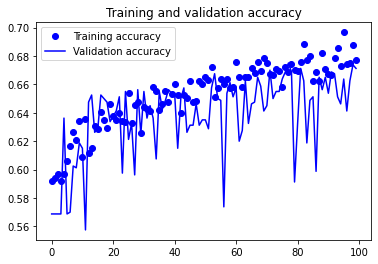

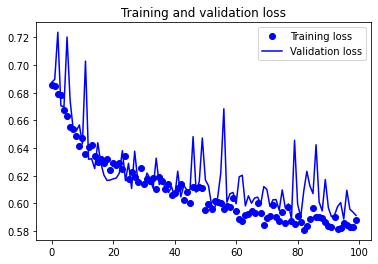

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model_3.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 5ms/step - loss: 0.6052 - acc: 0.6469
0.6468750238418579


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71       219
         1.0       0.49      0.58      0.53       117

    accuracy                           0.64       336
   macro avg       0.62      0.63      0.62       336
weighted avg       0.66      0.64      0.65       336



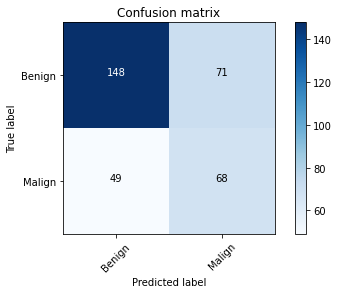

In [ ]:
model_3.load_weights(checkpoint_filepath)
plt_3 = plot_confusion_matrix(model_3,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_3.savefig(os.path.join(PLOTS_PATH, 'model_3_CM.png'))

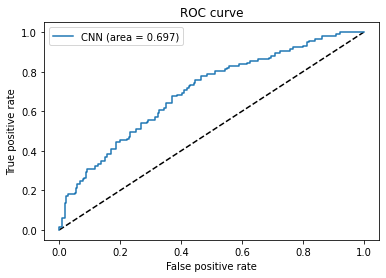

In [ ]:
plot_AUC(model_3, test_images, test_labels)

In [ ]:
predictions = get_model_pred_prob(model_3, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

### CNN Model No.4 Undersampling + data augmentation.

In [ ]:
undersampled_images, undersampled_labels = undersample(train_images, train_labels)

unique, counts = np.unique(undersampled_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])

In [ ]:
# split dataset into training and validation set 70-30
us_train_images_split, us_valid_images_split, us_train_labels_split, us_valid_labels_split = split_train_val(undersampled_images, undersampled_labels)  

In [ ]:
model_4 = build_model("binary_crossentropy", "acc")

#model_4.summary()

history = model_4.fit(train_datagen.flow(us_train_images_split,
                                       us_train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(us_train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(us_valid_images_split,
                                       us_valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(us_valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
77/77 [==============================] - 4s 45ms/step - loss: 0.6968 - acc: 0.5490 - val_loss: 0.9380 - val_acc: 0.2773
Epoch 2/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6788 - acc: 0.6116 - val_loss: 0.7726 - val_acc: 0.2773
Epoch 3/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6734 - acc: 0.6172 - val_loss: 0.7856 - val_acc: 0.2773
Epoch 4/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6753 - acc: 0.5918 - val_loss: 0.7211 - val_acc: 0.2833
Epoch 5/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6700 - acc: 0.6050 - val_loss: 0.7919 - val_acc: 0.2788
Epoch 6/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6656 - acc: 0.5972 - val_loss: 1.0215 - val_acc: 0.2773
Epoch 7/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6634 - acc: 0.5906 - val_loss: 0.7570 - val_acc: 0.4348
Epoch 8/100
77/77 [==============================] - 3s 41ms/step - loss: 0.

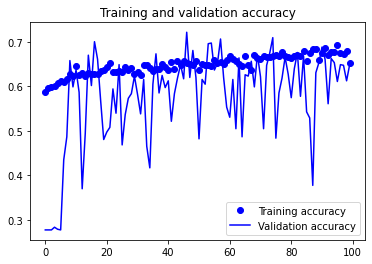

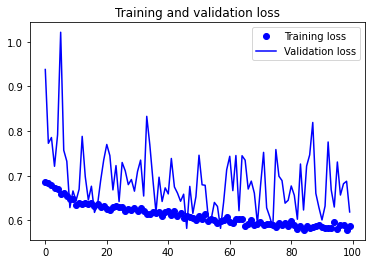

In [ ]:
plt = plot(history)
plt.show()

In [ ]:
test_loss, test_acc = model_4.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 5ms/step - loss: 0.6280 - acc: 0.6250
0.625


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.59      0.66       219
         1.0       0.46      0.66      0.54       117

    accuracy                           0.61       336
   macro avg       0.61      0.62      0.60       336
weighted avg       0.66      0.61      0.62       336



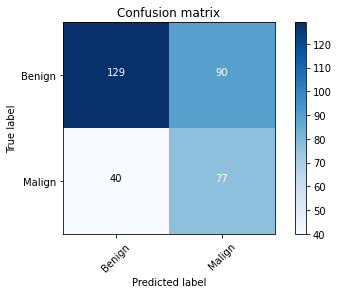

In [ ]:
model_4.load_weights(checkpoint_filepath)
plt_4 = plot_confusion_matrix(model_4,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_4.savefig(os.path.join(PLOTS_PATH, 'model_4_CM.png'))

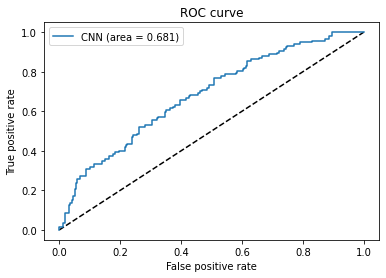

In [ ]:
plot_AUC(model_4, test_images, test_labels)

In [ ]:
predictions = get_model_pred_prob(model_4, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

### CNN Model No.5 Oversampling + data augmentation.

![img](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2020/08/10-oversampling.png?resize=768%2C407&ssl=1)

In [ ]:
#oversampling
def oversample(dataset, labels):
  unique, counts = np.unique(labels, return_counts=True)

  num_elems = np.max(counts) - np.min(counts)  
  zipped = list(zip(dataset, labels))

  oversampled_images = np.zeros((np.max(counts)*2,) +  dataset[0].shape) #(np.max(counts)*2, 150, 150, 1)
  oversampled_labels = np.zeros((np.max(counts)*2,))                     #(np.max(counts)*2, )

  #Benign samples:  1568
  #Malign samples:  1108

  i = 0
  benign_count = 0
  malign_count = 0
  malign_indexes = []
  for image, label in zipped:
    if label == 0 and benign_count < 1568:
      oversampled_images[i] = image 
      oversampled_labels[i] = label 
      benign_count += 1
      i += 1

    elif label == 1 and malign_count < 1108:
      oversampled_images[i] = image 
      oversampled_labels[i] = label 
      malign_count += 1
      malign_indexes.append(i)
      i += 1

    if malign_count == 1108:
      #generate array with [num_elems] random values in range [0, len(malign_indexes)]
      rands = np.random.randint(0, len(malign_indexes), num_elems)

      for value in rands:
        oversampled_images[i] = oversampled_images[value]
        oversampled_labels[i] = 1 
        i += 1
      break

  #print(oversampled_images.shape)
  #print(oversampled_labels.shape)

  return oversampled_images, oversampled_labels
  

oversampled_images, oversampled_labels = oversample(train_images, train_labels)

In [ ]:
unique, counts = np.unique(oversampled_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1568 1568]


In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(oversampled_images, oversampled_labels)  

(2195, 150, 150, 1)
(941, 150, 150, 1)
(2195,)
(941,)


In [ ]:
model_5 = build_model("binary_crossentropy", "acc")

#model_5.summary()

history = model_5.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
109/109 [==============================] - 5s 43ms/step - loss: 0.6852 - acc: 0.5853 - val_loss: 0.8898 - val_acc: 0.2862
Epoch 2/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6891 - acc: 0.5859 - val_loss: 0.8044 - val_acc: 0.2862
Epoch 3/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6835 - acc: 0.5806 - val_loss: 0.8863 - val_acc: 0.2862
Epoch 4/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6685 - acc: 0.5899 - val_loss: 0.7590 - val_acc: 0.4234
Epoch 5/100
109/109 [==============================] - 5s 42ms/step - loss: 0.6649 - acc: 0.6026 - val_loss: 0.9489 - val_acc: 0.2936
Epoch 6/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6507 - acc: 0.6257 - val_loss: 0.7189 - val_acc: 0.5053
Epoch 7/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6397 - acc: 0.6374 - val_loss: 0.8504 - val_acc: 0.3447
Epoch 8/100
109/109 [==============================] - 4s 41ms

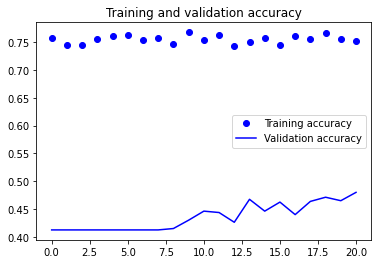

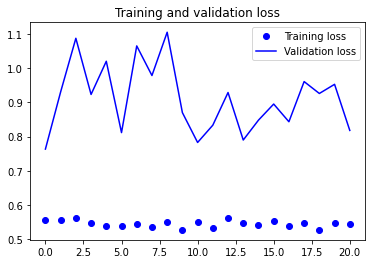

In [ ]:
plt = plot(history)
plt.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77       219
         1.0       0.54      0.38      0.44       117

    accuracy                           0.67       336
   macro avg       0.62      0.60      0.60       336
weighted avg       0.65      0.67      0.65       336



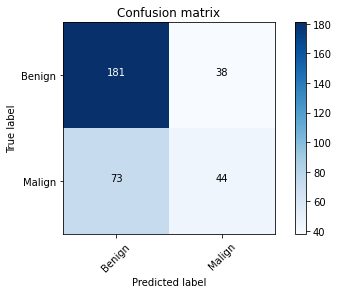

In [ ]:
model_5.load_weights(checkpoint_filepath)
plt_5 = plot_confusion_matrix(model_5,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_5.savefig(os.path.join(PLOTS_PATH, 'model_5_CM.png'))

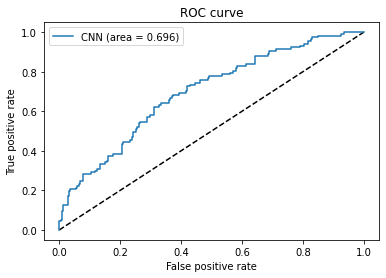

In [ ]:
plot_AUC(model_5, test_images, test_labels)

In [ ]:
predictions = get_model_pred_prob(model_5, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

### CNN Model No.6 Minority Class Oversampling through data augmentation.

In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)


In [ ]:
unique, counts = np.unique(train_labels_split, return_counts=True)
print(unique, counts)

[0. 1.] [1080  793]


In [ ]:
# Need Train data augmentation without rescaling (rescale all data before training) 
train_datagen = ImageDataGenerator(
    #rescale=1./65535,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
#minority class oversampling through data augmentation
def oversample_augmentation(dataset, labels, scale_factor_m, scale_factor_b):
  unique, counts = np.unique(labels, return_counts=True)
  num_benign = counts[0]
  num_malign = counts[1]

  zipped = list(zip(dataset, labels))

  benign_images = np.zeros((num_benign,) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  benign_labels = np.zeros((num_benign,))                       #(num_benign, )
  malign_images = np.zeros((num_malign,) +  dataset[0].shape)   #(num_malign, 150, 150, 1)
  malign_labels = np.zeros((num_malign,))                       #(num_malign, )

  #Benign samples:  1568
  #Malign samples:  1108

  benign_idx = 0
  malign_idx = 0
  for image, label in zipped:
    #get benign samples only
    if label == 0:
      benign_images[benign_idx] = image 
      benign_labels[benign_idx] = label 
      benign_idx += 1
    #get malign samples only
    elif label == 1:
      malign_images[malign_idx] = image 
      malign_labels[malign_idx] = label 
      malign_idx += 1

  #malign class oversampling through data augmentation
  malign_images_aug = np.zeros((int(num_benign*scale_factor_m),) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  malign_labels_aug = np.zeros((int(num_benign*scale_factor_m),))                       #(num_malign, )
 
  BATCH_size = 1
  i = 0
  for batch, labels_batch in train_datagen.flow(malign_images, malign_labels, batch_size=BATCH_size):
    malign_images_aug[i * BATCH_size : (i + 1) * BATCH_size] = batch
    malign_labels_aug[i * BATCH_size : (i + 1) * BATCH_size] = labels_batch
    i += 1

    if i * BATCH_size  >= int(num_benign*scale_factor_m):
      break

  #benign class oversampling through data augmentation
  benign_images_aug = np.zeros((int(num_benign*scale_factor_b),) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  benign_labels_aug = np.zeros((int(num_benign*scale_factor_b),))                       #(num_malign, )
 
  BATCH_size = 1
  i = 0
  for batch, labels_batch in train_datagen.flow(benign_images, benign_labels, batch_size=BATCH_size):
    benign_images_aug[i * BATCH_size : (i + 1) * BATCH_size] = batch
    benign_labels_aug[i * BATCH_size : (i + 1) * BATCH_size] = labels_batch
    i += 1

    if i * BATCH_size  >= int(num_benign*scale_factor_b):
      break

  


  #merge classes back
  train = np.concatenate((malign_images_aug, benign_images_aug), axis=0)
  labels = np.concatenate((malign_labels_aug, benign_labels_aug), axis=0)
  
  #print(malign_images_aug.shape)
  #print(malign_labels_aug.shape)
  #print(benign_images.shape)
  #print(benign_labels.shape)

  #shuffle data
  train, labels = shuffle_dataset(train, labels)

  return train, labels

In [ ]:
scale_factor_m = 2.6       # malign_samples/benign_samples ratio
scale_factor_b = 1.4
os_train_images, os_train_labels = oversample_augmentation(train_images_split, train_labels_split, scale_factor_m, scale_factor_b)

print(os_train_images.shape)
print(os_train_labels.shape)

(4320, 150, 150, 1)
(4320,)


In [ ]:
unique, counts = np.unique(os_train_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1512 2808]


In [ ]:
model_6 = build_model("binary_crossentropy", "acc")

model_6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

In [ ]:
history = model_6.fit(train_datagen.flow(os_train_images,
                                       os_train_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
93/93 [==============================] - 5s 43ms/step - loss: 0.6490 - acc: 0.6384 - val_loss: 0.7477 - val_acc: 0.3938
Epoch 2/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6406 - acc: 0.6500 - val_loss: 0.7968 - val_acc: 0.3938
Epoch 3/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6422 - acc: 0.6454 - val_loss: 0.8365 - val_acc: 0.3938
Epoch 4/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6376 - acc: 0.6479 - val_loss: 0.7335 - val_acc: 0.4000
Epoch 5/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6424 - acc: 0.6460 - val_loss: 0.8398 - val_acc: 0.3938
Epoch 6/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6407 - acc: 0.6470 - val_loss: 0.7846 - val_acc: 0.4175
Epoch 7/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6218 - acc: 0.6659 - val_loss: 0.9509 - val_acc: 0.3975
Epoch 8/100
93/93 [==============================] - 4s 40ms/step - loss: 0.

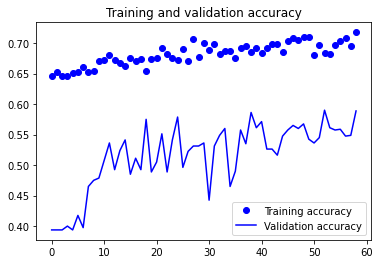

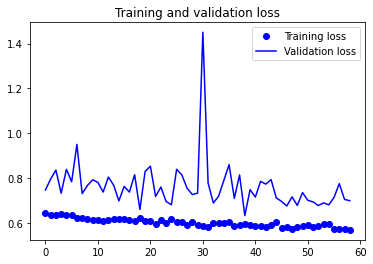

In [ ]:
plt = plot(history)
plt.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.41      0.54       219
         1.0       0.41      0.78      0.54       117

    accuracy                           0.54       336
   macro avg       0.59      0.59      0.54       336
weighted avg       0.65      0.54      0.54       336



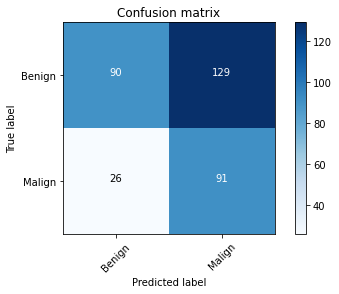

In [ ]:
model_6.load_weights(checkpoint_filepath)
classes = ["Benign", "Malign"]
plt_6 = plot_confusion_matrix(model_6,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_6.savefig(os.path.join(PLOTS_PATH, 'model_6_CM_SF_2.4.png'))

In [ ]:
test_loss, test_acc = model_6.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 0.6994 - acc: 0.5469
0.546875


In [ ]:
predictions = get_model_pred_prob(model_6, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  91
FP:  129
TN:  90
FN:  26


(0.7777777777777778, 0.589041095890411)

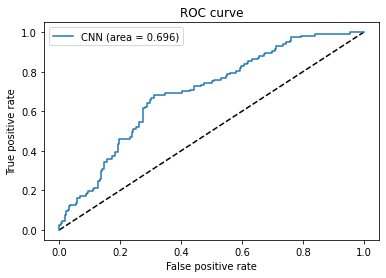

In [ ]:

plot_AUC(model_6, test_images, test_labels)

### CNN Model No.7 SMOTE: Synthetic Minority Oversampling Technique

In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)


In [ ]:
#reshape tensors for SMOTE: (num_samples, 150*150*1)
shape = (len(train_images_split), 150*150)
train_images_SMOTE = train_images_split.reshape(shape) 
print(train_images_SMOTE.shape)
print(train_labels_split.shape)

(1873, 22500)
(1873,)


In [ ]:
#SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

counter = Counter(train_labels_split)
print('Original dataset shape %s' % counter)
"""
# define pipeline

# use random undersampling to reduce the number 
# of examples in the majority class to have 50 percent 
# more than the minority class 
under = RandomUnderSampler(sampling_strategy=1, replacement=True)


# oversampling minority class in such a way that 
# it has 0.9*num_samples_majority_class samples 
over = SMOTE(sampling_strategy=0.93, n_jobs=-1)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_res, y_res = pipeline.fit_resample(train_images_SMOTE, train_labels_split)
counter = Counter(y_res)
print('Resampled dataset shape %s' % counter)
"""


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_images_SMOTE, train_labels_split)
counter = Counter(y_res)
print('Resampled dataset shape %s' % counter)



Original dataset shape Counter({0.0: 1116, 1.0: 757})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({0.0: 1116, 1.0: 1116})


In [ ]:
#reshape back tensors for model fitting
shape = (len(X_res), 150, 150, 1)
train_images_SMOTE = X_res.reshape(shape) 

print(train_images_SMOTE.shape)
print(y_res.shape)

(2232, 150, 150, 1)
(2232,)


In [ ]:
# Need Train data augmentation without rescaling (rescale all data before training) 
train_datagen = ImageDataGenerator(
    #rescale=1./65535,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
scale_factor = 2        # malign_samples/benign_samples ratio
train_images_SMOTE, y_res = oversample_augmentation(train_images_SMOTE, y_res, scale_factor)

print(train_images_SMOTE.shape)
print(y_res.shape)

(3348, 150, 150, 1)
(3348,)


In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

In [ ]:
model_7 = build_model("binary_crossentropy", "acc")

model_7.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 15, 15, 128)     

In [ ]:
history = model_7.fit(train_datagen.flow(train_images_SMOTE,
                                       y_res,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
93/93 [==============================] - 6s 52ms/step - loss: 0.6183 - acc: 0.6568 - val_loss: 0.7627 - val_acc: 0.4375
Epoch 2/100
93/93 [==============================] - 4s 48ms/step - loss: 0.5843 - acc: 0.6530 - val_loss: 0.7324 - val_acc: 0.4375
Epoch 3/100
93/93 [==============================] - 5s 49ms/step - loss: 0.5730 - acc: 0.6605 - val_loss: 0.7303 - val_acc: 0.4387
Epoch 4/100
93/93 [==============================] - 5s 49ms/step - loss: 0.5735 - acc: 0.6594 - val_loss: 0.7260 - val_acc: 0.4625
Epoch 5/100
93/93 [==============================] - 5s 48ms/step - loss: 0.5845 - acc: 0.6730 - val_loss: 0.6808 - val_acc: 0.5288
Epoch 6/100
93/93 [==============================] - 4s 48ms/step - loss: 0.6140 - acc: 0.6940 - val_loss: 0.6737 - val_acc: 0.5562
Epoch 7/100
93/93 [==============================] - 4s 47ms/step - loss: 0.5521 - acc: 0.6977 - val_loss: 0.6688 - val_acc: 0.5663
Epoch 8/100
93/93 [==============================] - 4s 47ms/step - loss: 0.

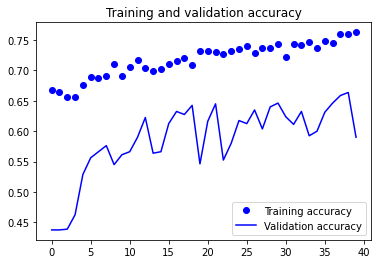

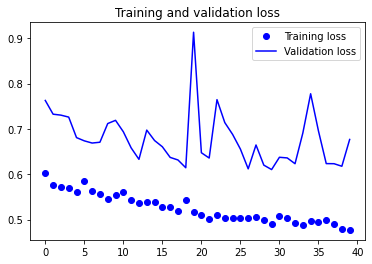

In [ ]:
plt = plot(history)
plt.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       219
         1.0       0.54      0.45      0.49       117

    accuracy                           0.68       336
   macro avg       0.64      0.62      0.63       336
weighted avg       0.66      0.68      0.67       336



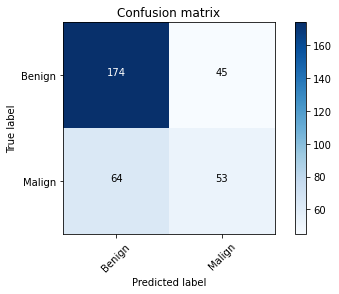

In [ ]:
model_7.load_weights(checkpoint_filepath)
classes = ["Benign", "Malign"]
plt_7 = plot_confusion_matrix(model_7,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_7.savefig(os.path.join(PLOTS_PATH, 'model_7_CM.png'))

In [ ]:
test_loss, test_acc = model_7.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.5882 - acc: 0.6844
0.684374988079071


In [ ]:
predictions = get_model_pred_prob(model_7, test_images, test_labels, len(test_images))
calc_TP_FP_rate(test_labels, predictions)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  53
FP:  45
TN:  174
FN:  64


(0.452991452991453, 0.2054794520547945)

### Just Playing. CNN Model No.8 Normalization



In [ ]:
def build_model8():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  #model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  #model.add(layers.BatchNormalization())


  model.compile(loss='binary_crossentropy', 
                optimizer=optimizers.Adam(),
                metrics =['acc'])
  
  return model 

In [ ]:
model_8 = build_model8()
model_8.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 128)      

In [ ]:
history = model_8.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
93/93 [==============================] - 3s 25ms/step - loss: 3.7765 - acc: 0.5536 - val_loss: 3.0937 - val_acc: 0.5800
Epoch 2/100
93/93 [==============================] - 2s 23ms/step - loss: 1.7262 - acc: 0.5984 - val_loss: 1.8917 - val_acc: 0.5800
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 1.3909 - acc: 0.6775 - val_loss: 1.5675 - val_acc: 0.5800
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 1.2443 - acc: 0.6787 - val_loss: 1.7278 - val_acc: 0.5800
Epoch 5/100
93/93 [==============================] - 2s 23ms/step - loss: 1.1072 - acc: 0.6828 - val_loss: 1.5521 - val_acc: 0.5987
Epoch 6/100
93/93 [==============================] - 2s 23ms/step - loss: 1.0035 - acc: 0.7353 - val_loss: 1.1005 - val_acc: 0.5913
Epoch 7/100
93/93 [==============================] - 2s 23ms/step - loss: 0.9258 - acc: 0.7339 - val_loss: 2.1364 - val_acc: 0.5138
Epoch 8/100
93/93 [==============================] - 2s 23ms/step - loss: 0.

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70       219
         1.0       0.47      0.55      0.51       117

    accuracy                           0.63       336
   macro avg       0.60      0.61      0.60       336
weighted avg       0.64      0.63      0.63       336



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

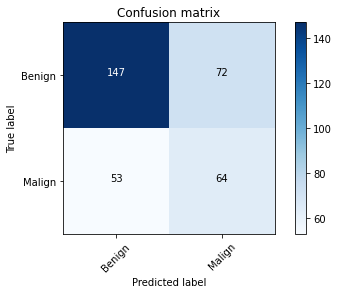

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plot_confusion_matrix(model_8,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

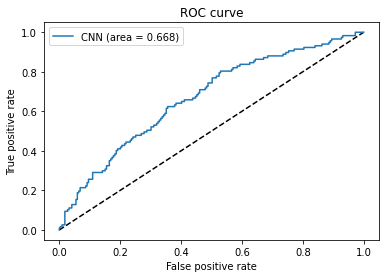

In [ ]:
plot_AUC(model_8, test_images, test_labels)

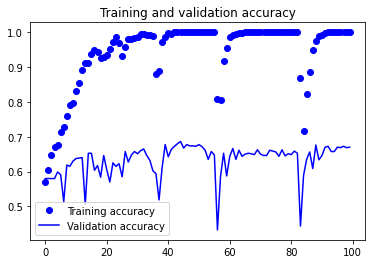

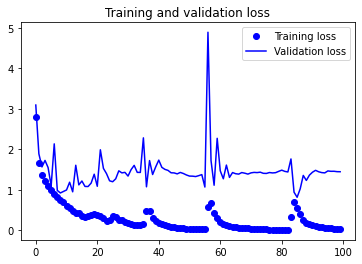

In [ ]:
plt = plot(history)

### Just Playing Again. CNN Model No.9 Dropout and BatchNormalization

In [127]:
param = 0.01

def build_model9():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(param), input_shape=(150, 150, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(param)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(param)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(param)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(param)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(param)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(param)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid'))
  
  # compile model
  opt = optimizers.Adam(lr=0.0001) # , beta_1=0.9, beta_2 = 0.999
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

  return model

In [128]:
model_9 = build_model9()
model_9.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_117 (Bat (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_118 (Bat (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 75, 75, 64)      

In [129]:
history = model_9.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
93/93 [==============================] - 7s 59ms/step - loss: 2.1389 - acc: 0.5564 - val_loss: 5.7350 - val_acc: 0.5838
Epoch 2/100
93/93 [==============================] - 5s 57ms/step - loss: 2.0597 - acc: 0.5851 - val_loss: 2.1333 - val_acc: 0.5850
Epoch 3/100
93/93 [==============================] - 5s 57ms/step - loss: 1.9883 - acc: 0.5972 - val_loss: 1.9703 - val_acc: 0.5825
Epoch 4/100
93/93 [==============================] - 5s 57ms/step - loss: 1.8465 - acc: 0.5866 - val_loss: 1.6919 - val_acc: 0.6075
Epoch 5/100
93/93 [==============================] - 5s 57ms/step - loss: 1.7389 - acc: 0.5683 - val_loss: 1.6363 - val_acc: 0.6087
Epoch 6/100
93/93 [==============================] - 5s 57ms/step - loss: 1.6285 - acc: 0.5851 - val_loss: 1.5217 - val_acc: 0.6100
Epoch 7/100
93/93 [==============================] - 5s 58ms/step - loss: 1.4966 - acc: 0.6132 - val_loss: 1.4450 - val_acc: 0.6100
Epoch 8/100
93/93 [==============================] - 5s 57ms/step - loss: 1.

In [131]:
print(train_images_split.shape)

(1873, 150, 150, 1)


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.88      0.03      0.06       219
         1.0       0.35      0.99      0.52       117

    accuracy                           0.37       336
   macro avg       0.61      0.51      0.29       336
weighted avg       0.69      0.37      0.22       336



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

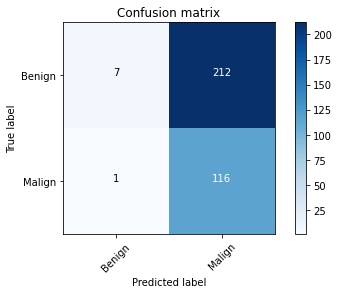

In [132]:
#print confusion matrix
classes = ["Benign", "Malign"]
plot_confusion_matrix(model_9,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

In [133]:
unique, counts = np.unique(test_labels, return_counts=True)

print(unique, counts)

[0. 1.] [219 117]


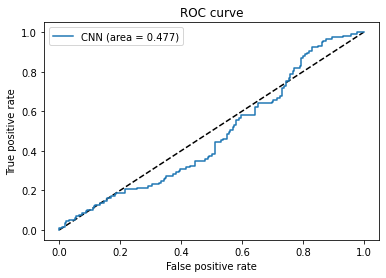

In [134]:
plot_AUC(model_9, test_images, test_labels)

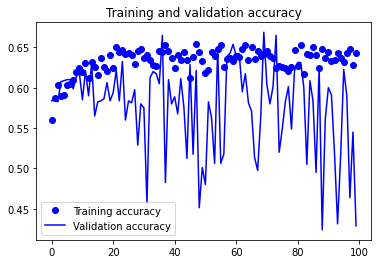

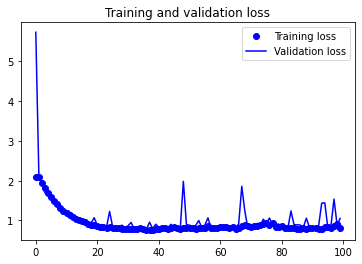

In [135]:
plt = plot(history)